# Subjects Independent Experiments

In [ ]:
#total subjects separated into 80-20 train-test split

In [ ]:
## FOR GOOGLE COLLAB ONLY
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## FOR GOOGLE COLLAB ONLY
#extract EEG & FNIRS data
#cp /content/drive/MyDrive/Data.zip .
#!unzip -qq Data.zip

In this notebook, we will apply EF-Net classifier to Hybrid EEG + fNIRS data with the data split in a Subject Independent setting. We also have the Deep Learning baselines here, that can be implemented using the 'baseline_model' boolean set to True, and further the 'resnet' boolean which indicates a resnet baseline to be used, if resnet==False, then the VGG baseline shall be implemented.

The current settings in this file will run the EF-Net model. (baseline_model==False)
Deep learning parameters were set according to the table in the appendix of our published paper: [EF-Net: Mental State Recognition by Analyzing Multimodal EEG-fNIRS via CNN](https://doi.org/10.3390/s24061889)

The dataset we have used is called: Simultaneous Acquisition of EEG and NIRS during Cognitive Tasks for
an Open Access Dataset,
    and is available here: https://doc.ml.tu-berlin.de/simultaneous_EEG_NIRS/. We are using Dataset C for classification.
    There is 72 fNIRS channels and 30 EEG channels. The dataset has 26 subjects in total. Each subject has data of 60 trials: which includes 3 sessions per subject, each session has 20 trials, each trial has 10 Word Generation tasks, and 10 Baseline tasks. This brings each subject to a total of 60 trials of either WG or BL tasks, performed in random order. Here we will further use those 60 trials to create 360 samples per subject, by using a sliding window technique across each trial.

In [ ]:
import numpy as np
import tensorflow as tf
from data_preprocess import extract_subj_indep
import hybrid_model_structures as models

### Inputs - enter here:

In [ ]:
#INPUT

#subjects directory path
#The data should be extracted in the same directory as this script.
dir_path_f = "./FNIRS_data/FNIRS2/NIRS_01-26_MATLAB/"
dir_path_e="./EEG_data/EEG2/EEG_01-26_MATLAB/"

#######################
#Deep Learning settings:

baseline_model=False
resnet=False
if baseline_model:
    lr=1e-5
    EPOCHS=100
else:
    lr=5e-5
    EPOCHS=40
BATCH_SIZE = 64

RANDOM_STATE=38

In [ ]:
Xeeg_train, Xfnirs_train, Y_train, Xeeg_test, Xfnirs_test, Y_test= extract_subj_indep(dir_path_e,dir_path_f,baseline_model,RANDOM_STATE)

Subject Count: 26
[14, 17, 6, 8, 5, 12, 9, 0, 24, 20, 7, 18, 3, 23, 15, 13, 22, 10, 16, 25, 2, 4, 19, 21, 11, 1]
fnirs len 20245
eeg len 372182
Subject  15 is done. Length of X_train,X_test is now: 360 0 and length of Y_train, Y_test is:  360 0
fnirs len 20295
eeg len 372437
Subject  18 is done. Length of X_train,X_test is now: 720 0 and length of Y_train, Y_test is:  720 0
fnirs len 20145
eeg len 371449
Subject  7 is done. Length of X_train,X_test is now: 1080 0 and length of Y_train, Y_test is:  1080 0
fnirs len 20241
eeg len 371618
Subject  9 is done. Length of X_train,X_test is now: 1440 0 and length of Y_train, Y_test is:  1440 0
fnirs len 20191
eeg len 371874
Subject  6 is done. Length of X_train,X_test is now: 1800 0 and length of Y_train, Y_test is:  1800 0
fnirs len 20210
eeg len 371163
Subject  13 is done. Length of X_train,X_test is now: 2160 0 and length of Y_train, Y_test is:  2160 0
fnirs len 20191
eeg len 371869
Subject  10 is done. Length of X_train,X_test is now: 2520 

We now have an array of 360 samples per subject, with a total of 9360 samples as shown across the train and test in output above. Each sample is a 5 second window from the task data, with one second of overlap with the previous sample.  
Secondly, we have an array Y made from the labels (y) array in session_markers from the dataset, and by appending the corresponding classes across the samples taken, we have 360 trial labels per subject in the Y array, totalling 9360 labels across all subjects' trials.

### Standardizing the data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Standardize our signals data
# Reshaping the data samples into 2D applying the scaling and then reshaping back
scaler = StandardScaler()
Xeeg_trainS = scaler.fit_transform(Xeeg_train.reshape(-1, Xeeg_train.shape[-1])).reshape(Xeeg_train.shape)
Xeeg_testS = scaler.transform(Xeeg_test.reshape(-1, Xeeg_test.shape[-1])).reshape(Xeeg_test.shape)

Xfnirs_trainS = scaler.fit_transform(Xfnirs_train.reshape(-1, Xfnirs_train.shape[-1])).reshape(Xfnirs_train.shape)
Xfnirs_testS = scaler.transform(Xfnirs_test.reshape(-1, Xfnirs_test.shape[-1])).reshape(Xfnirs_test.shape)

print(Xeeg_trainS.shape)
print(Xfnirs_trainS.shape)

#adjustment to labels to make compatible with binary_crossentropy
Y_train=Y_train[:,0]
Y_test=Y_test[:,0]

(7200, 500, 30)
(7200, 25, 72)


In [ ]:
#reshaping data into correct form for input into models.
if baseline_model:
    Xeeg_trainS_3D=Xeeg_trainS
    Xeeg_testS_3D=Xeeg_testS
    Xfnirs_trainS_3D=Xfnirs_trainS
    Xfnirs_testS_3D=Xfnirs_testS
else:
    #reshape into 2D and 1 channel data (3D samples list) for EF-Net.
    Xeeg_trainS_3D=np.reshape(Xeeg_trainS,(Xeeg_trainS.shape[0],Xeeg_trainS.shape[1],Xeeg_trainS.shape[2],1))
    Xeeg_testS_3D=np.reshape(Xeeg_testS,(Xeeg_testS.shape[0],Xeeg_testS.shape[1],Xeeg_testS.shape[2],1))
    Xfnirs_trainS_3D=np.reshape(Xfnirs_trainS,(Xfnirs_trainS.shape[0],Xfnirs_trainS.shape[1],Xfnirs_trainS.shape[2],1))
    Xfnirs_testS_3D=np.reshape(Xfnirs_testS,(Xfnirs_testS.shape[0],Xfnirs_testS.shape[1],Xfnirs_testS.shape[2],1))
    Xeeg_trainS_3D.shape

### Applying a deep neural network to our data

In [ ]:
if baseline_model:
    hybridmodel= models.eeg_fnirs_vgg(Xeeg_trainS_3D,Xfnirs_trainS_3D,resnet)
else:
    hybridmodel= models.eeg_fnirs_cnn_v2()

In [ ]:
hybridmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 30, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 494, 30, 32)          256       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 488, 30, 32)          7200      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 482, 30, 32)          7200      ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
from tensorflow.keras.optimizers import Adam

hybridmodel.compile(optimizer=Adam(learning_rate=lr),loss='binary_crossentropy',metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
#save best model

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
hybridmodel.fit(x=[Xeeg_trainS_3D, Xfnirs_trainS_3D], y=Y_train, validation_data=([Xeeg_testS_3D, Xfnirs_testS_3D], Y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback])

Epoch 1/40
113/113 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5096 - precision: 0.5070 - recall: 0.6928 - auc: 0.5208
Epoch 1: val_accuracy improved from -inf to 0.50417, saving model to /tmp/checkpoint
113/113 [==============================] - 24s 72ms/step - loss: 0.6925 - accuracy: 0.5096 - precision: 0.5070 - recall: 0.6928 - auc: 0.5208 - val_loss: 0.6904 - val_accuracy: 0.5042 - val_precision: 0.5021 - val_recall: 0.9880 - val_auc: 0.6178
Epoch 2/40
112/113 [============================>.] - ETA: 0s - loss: 0.6910 - accuracy: 0.5371 - precision: 0.5293 - recall: 0.6736 - auc: 0.5487
Epoch 2: val_accuracy improved from 0.50417 to 0.50463, saving model to /tmp/checkpoint
113/113 [==============================] - 6s 52ms/step - loss: 0.6910 - accuracy: 0.5375 - precision: 0.5295 - recall: 0.6742 - auc: 0.5490 - val_loss: 0.6894 - val_accuracy: 0.5046 - val_precision: 0.5024 - val_recall: 0.9639 - val_auc: 0.6209
Epoch 3/40
113/113 [====================

In [ ]:
hybridmodel.load_weights(checkpoint_filepath)

In [ ]:
probabilities = hybridmodel.predict([Xeeg_testS_3D, Xfnirs_testS_3D])

68/68 [==============================] - 1s 12ms/step


In [ ]:
y_preds= np.round(probabilities)

Text(17.25, 0.5, 'Actual label')

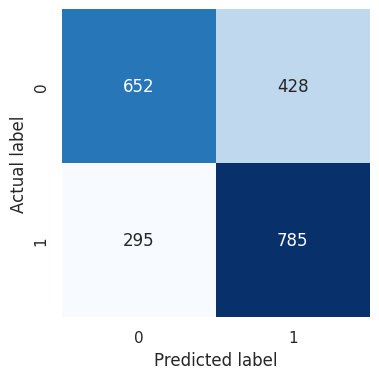

In [ ]:
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()

plt.figure(figsize=(4,4))

mat = confusion_matrix(Y_test, y_preds )
labels = [0,1]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:
#model performance on unseen data
loss,accuracy,precision,recall,AUC = hybridmodel.evaluate([Xeeg_testS_3D,Xfnirs_testS_3D], Y_test)

68/68 [==============================] - 1s 8ms/step - loss: 0.6723 - accuracy: 0.6653 - precision: 0.6472 - recall: 0.7269 - auc: 0.6846


In [ ]:
print("baseline model=", baseline_model)
print("resnet=", resnet)
print("seed=",RANDOM_STATE)
print("lr=", lr)

baseline model= False
resnet= False
seed= 38
lr= 5e-05
